In [2]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using Plots; gr();

  Activating project at `~/Coding/julia/FUSE`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1423


build
  is_nuclear_facility ➡ true
  n_oh_coils ➡ 6
  n_pf_coils_inside ➡ 0
  n_pf_coils_outside ➡ 6
coil
  green_model ➡ simple
equilibrium
  Z0 ➡ 0.0
  field_null_surface ➡ 0.25
  ngrid ➡ 129
gasc
  no_small_gaps ➡ true
general
  init_from ➡ ods
ods
  filename ➡ /Users/meneghini/Coding/julia/FUSE/src/../sample/ITER_eq_ods.json


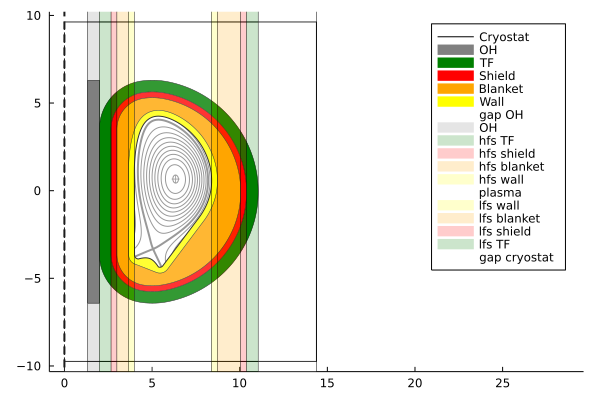

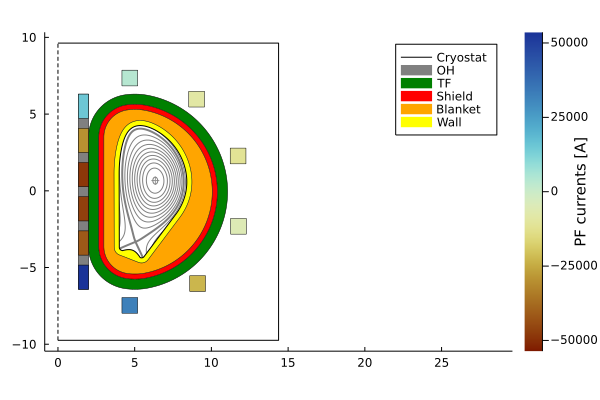

equilibrium.ids_properties was skipped in IMAS.jl data dictionary
equilibrium.ids_properties was skipped in IMAS.jl data dictionary
equilibrium.ids_properties was skipped in IMAS.jl data dictionary


In [127]:
par = Parameters(:ITER,init_from=:ods)
#par = Parameters(:ITER,init_from=:scalars)
#par = Parameters(:D3D)
#par = Parameters(:FPP)
#par = Parameters(:CAT)
display(par)

dd=IMAS.dd()

FUSE.init_equilibrium(dd, par)
plot(dd.equilibrium)

FUSE.init_build(dd, par)
plot(dd.equilibrium, color = :gray)
plot!(dd.build, outline = true)
display(plot!(dd.build, cx = false))

plot(dd.equilibrium, color = :gray)
FUSE.init_pf_active(dd, par)
plot!(dd.build, outline = true)
display(plot!(dd.pf_active))

pfoptactor = FUSE.PFcoilsOptActor(dd; green_model = par.coil.green_model)
FUSE.step(pfoptactor, λ_ψ = 1E-2, λ_null = 1E10, λ_currents = 5E5, λ_strike = 0.0, verbose = false, symmetric = false, maxiter = 1000, optimization_scheme = :rail)
FUSE.finalize(pfoptactor)

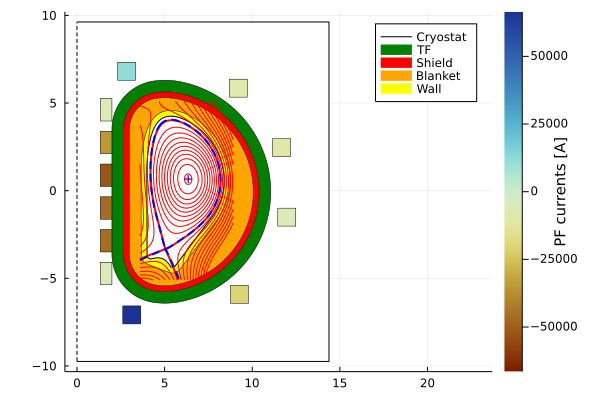

In [128]:
display(plot(pfoptactor,time_index=2))

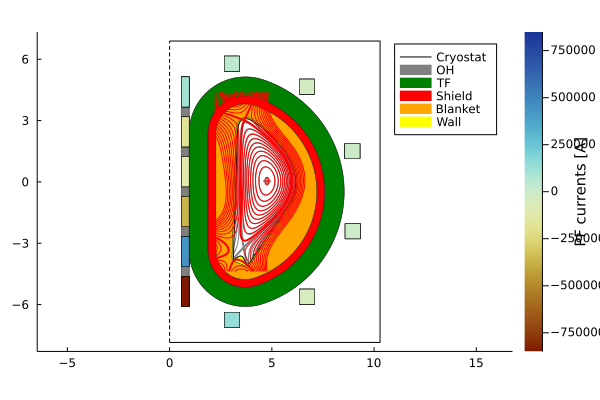

In [107]:
display(plot!(dd.pf_active))

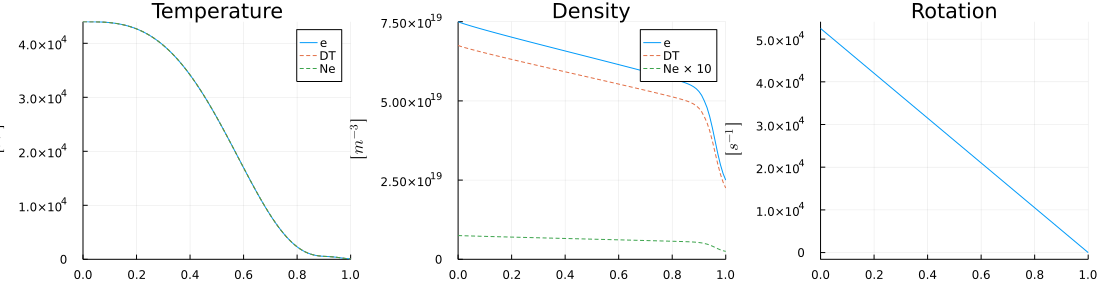

LoadError: BoundsError: attempt to access 51-element Vector{Float64} at index [58]

In [50]:
FUSE.init_core_profiles(dd; ne_ped=5E19, ne_peaking=1.5, Te_ped=500, Te_peaking=3, w_ped=0.08, zeff=1.9, Paux=10e6, n_points=101, bulk=:DT, impurity=:Ne)
FUSE.init_core_sources(dd; Paux_e=5e6, Paux_i=5e6);

p3=plot(layout=(1,3))
display(plot(p3,dd.core_profiles))

tauennactor = FUSE.TaueNNactor(dd, use_tglfnn=true, error=1E-2)
@time FUSE.step(tauennactor;verbose=false)
FUSE.finalize(tauennactor)

display(plot!(p3,dd.core_profiles,label="",linewidth=2))

In [89]:
IMAS.calc_beta_thermal_norm!(dd.summary, dd.equilibrium, dd.core_profiles)

1.8292867262199326